<h4>Libs and housekeeping</h4>

In [2]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import time
import statsmodels.api as sm

from pandas.plotting        import autocorrelation_plot
from statsmodels.tsa.stattools     import pacf,acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression

In [3]:
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)
rnd = np.random.RandomState(RANDOM_STATE)
NOISE = 0.1
TEST_SIZE = 0.2
ALPHA = 0.001
N_SAMPLES = 1000


In [4]:
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 7),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1,
          'scatter.edgecolors': 'b' 
         }

CMAP = plt.cm.brg
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('seaborn-v0_8-darkgrid')

<Figure size 1500x700 with 0 Axes>

<h4>get some data tooo</h4>

In [6]:
csvName = 'quarterly-beer-production-in-aus-March 1956-June 1994.csv'
data_df = pd.read_csv('quarterly-beer-production-in-aus-March 1956-June 1994.csv')

data_df.columns = ['quarter','production']
data_df.head()

,quarter,production
0,1956Q1,284.4
1,1956Q2,212.8
2,1956Q3,226.9
3,1956Q4,308.4
4,1957Q1,262.0


<h4>EDA on the data</h4>

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   quarter     154 non-null    object 
 1   production  154 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


In [9]:
data_df.isnull().sum()

quarter       0
production    0
dtype: int64

In [10]:
data_df.describe()

,production
count,154.000000
mean,408.267532
std,97.598588
min,212.800000
25%,325.425000
50%,427.450000
75%,466.950000
max,600.000000


In [11]:
def fn_quarter_to_datetime(quarter_str):
    year, quarter = quarter_str.split('Q')
    month = np.int16(quarter)*3-2

    return pd.to_datetime(f'{year}-{month:02d}')

In [12]:
data_df['date'] = data_df['quarter'].apply(fn_quarter_to_datetime)
data_df.head()

,quarter,production,date
0,1956Q1,284.4,1956-01-01
1,1956Q2,212.8,1956-04-01
2,1956Q3,226.9,1956-07-01
3,1956Q4,308.4,1956-10-01
4,1957Q1,262.0,1957-01-01


In [13]:
data_df['date'].dt.year.unique()

array([1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
       1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
       1989, 1990, 1991, 1992, 1993, 1994])

<Axes: xlabel='date', ylabel='production'>

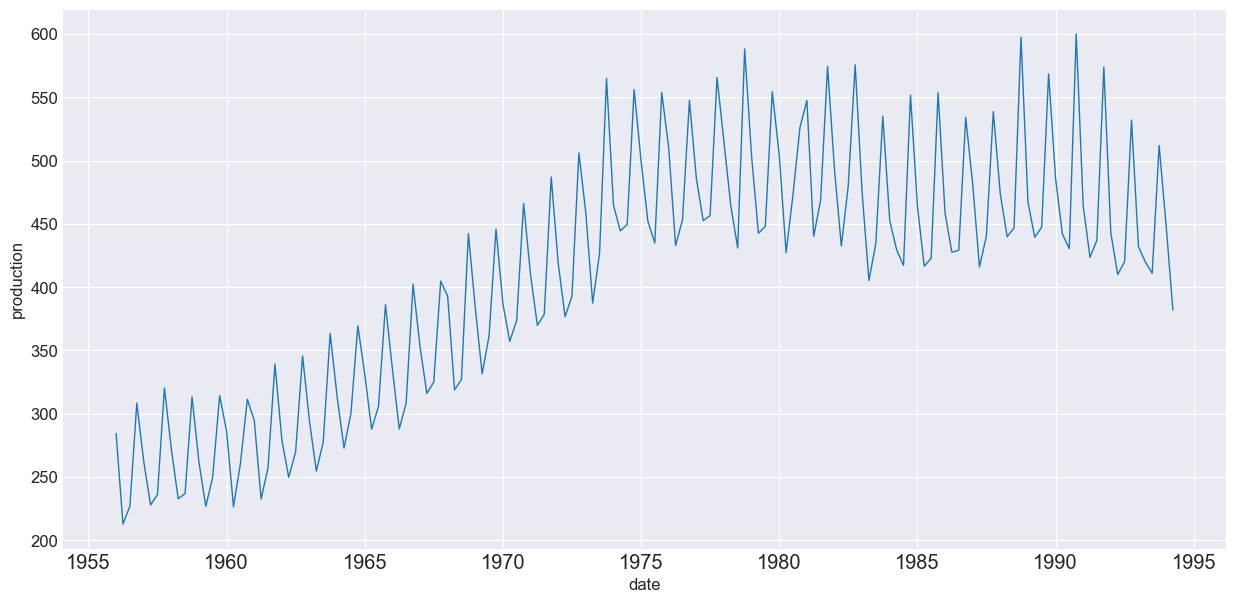

In [14]:

sns.lineplot(data = data_df, x = 'date', y = 'production')

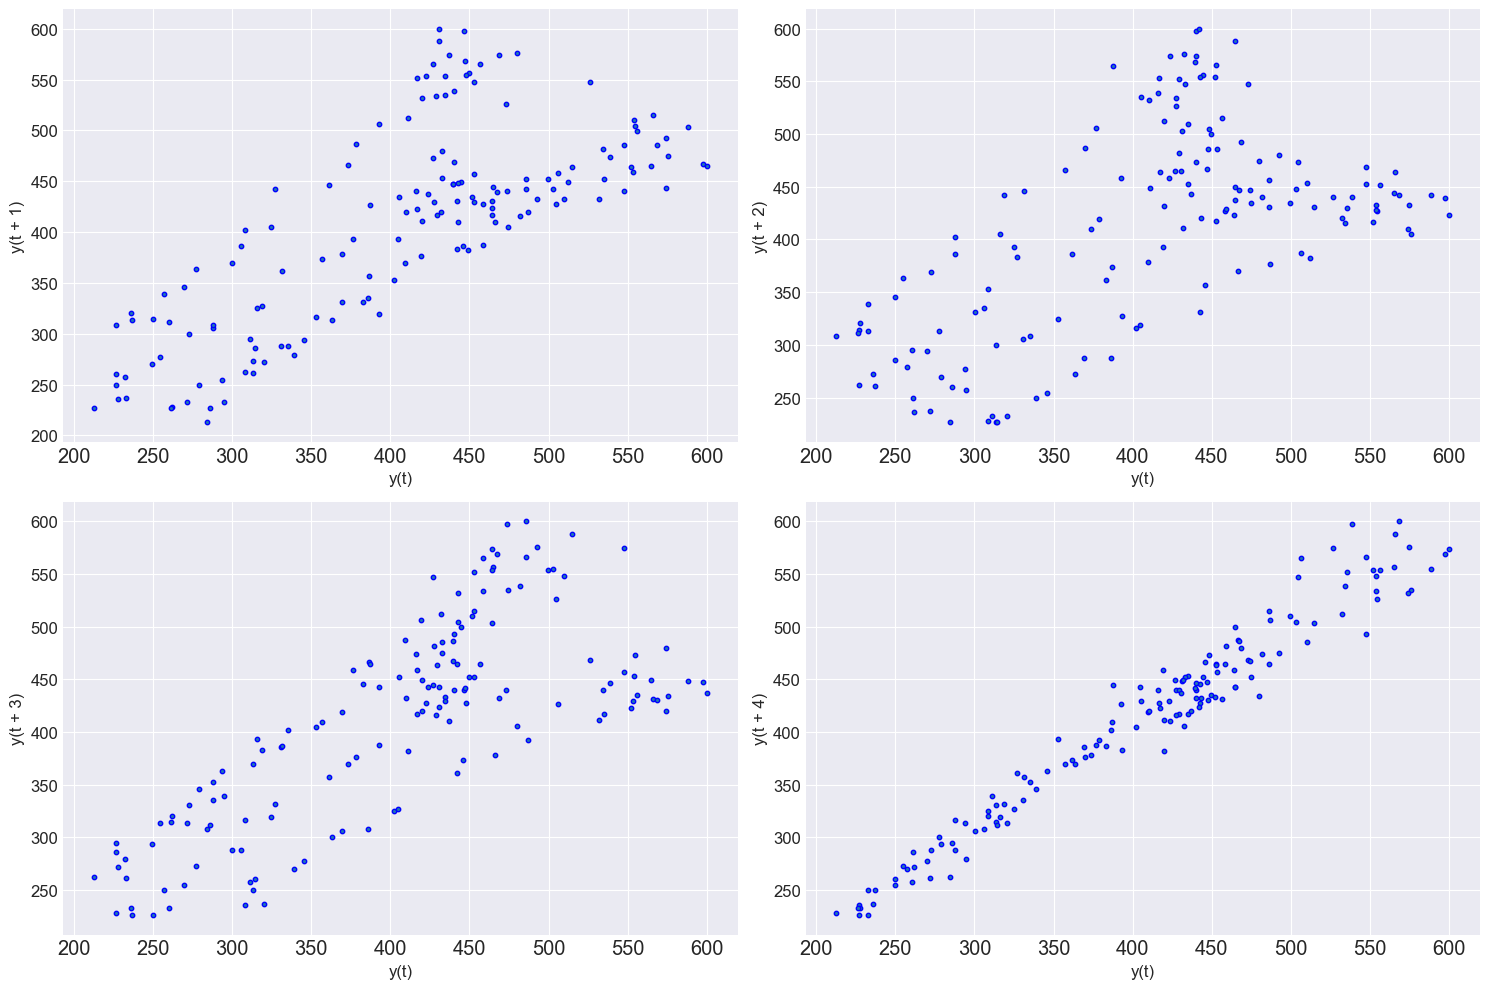

In [15]:
fig ,axes = plt.subplots(2,2,  figsize =  (15,10))

for count , ax in enumerate(axes.ravel()):
    pd.plotting.lag_plot(data_df['production'], lag=count+1, ax= ax, s = 10)

plt.tight_layout()

In [16]:
lag = np.arange(1,7)
data_acf = []

for l in lag:
    data_acf.append(data_df['production'].autocorr(l))

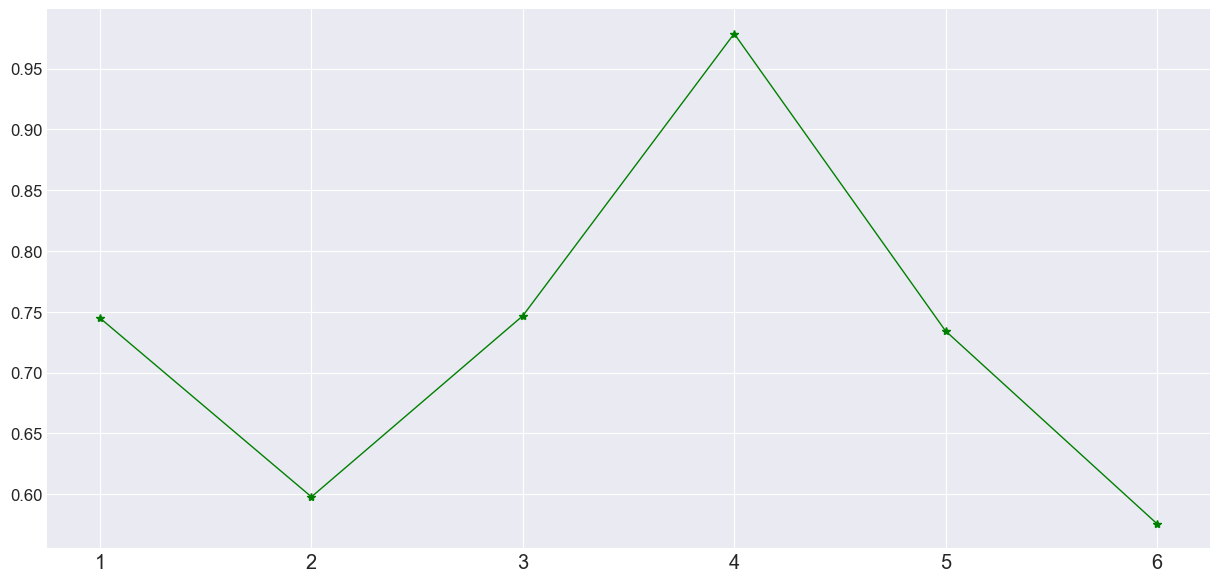

In [17]:
fig,ax = plt.subplots()
ax.plot(lag, data_acf, marker = '*', color = 'g')

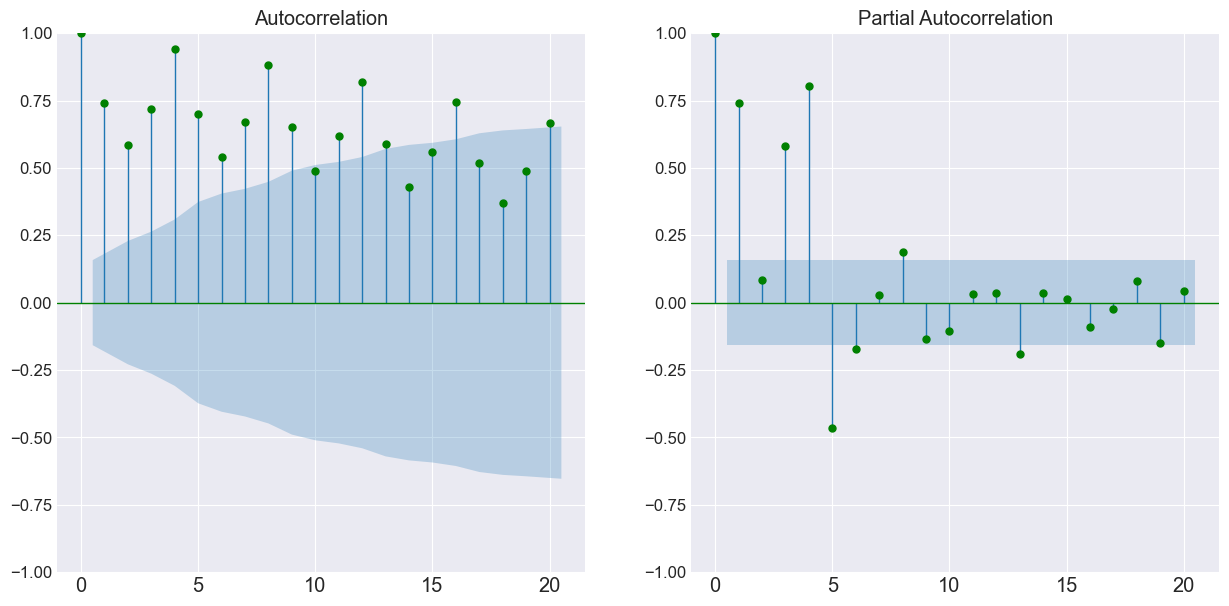

In [18]:
fig,axes = plt.subplots(1,2)
_=plot_acf(data_df['production'], lags = 20, color = 'g', ax = axes[0])
_=plot_pacf(data_df['production'], lags = 20, color = 'g', ax = axes[1])

In [19]:
def get_trend(timeseries, deg = 3):

    x     = list(range(len(timeseries)))
    y     = timeseries.values
    coef  = np.polyfit(x, y, deg)
    trend = np.poly1d(coef)(x)

    return pd.Series(data = trend, index = timeseries.index)

In [20]:
data_df['Trend'] = get_trend(data_df['production'])
data_df.head()

,quarter,production,date,Trend
0,1956Q1,284.4,1956-01-01,232.006953
1,1956Q2,212.8,1956-04-01,234.321738
2,1956Q3,226.9,1956-07-01,236.678431
3,1956Q4,308.4,1956-10-01,239.075917
4,1957Q1,262.0,1957-01-01,241.513080


<Axes: xlabel='date', ylabel='production'>

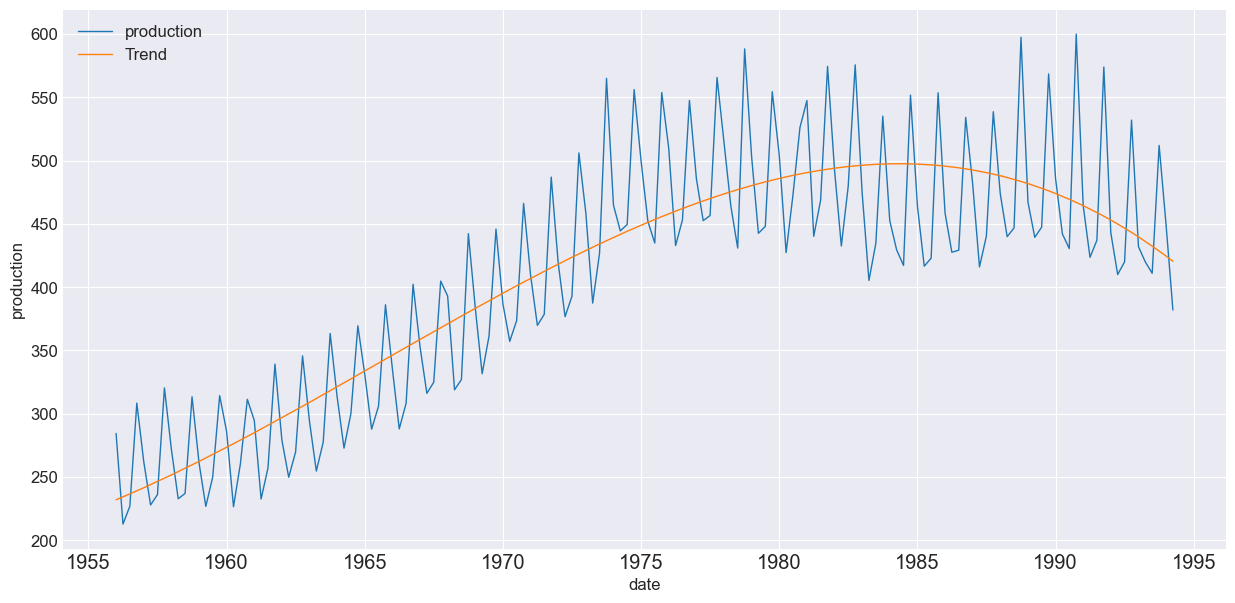

In [21]:
fig , ax = plt.subplots()

sns.lineplot(data=data_df, x = 'date', y = 'production', label = 'production', ax=ax)
sns.lineplot(data=data_df, x = 'date', y = 'Trend', label = 'Trend', ax=ax)

In [22]:
data_df['year'] = data_df['date'].dt.year
data_df['month'] = data_df['date'].dt.month

data_df.head()

,quarter,production,date,Trend,year,month
0,1956Q1,284.4,1956-01-01,232.006953,1956,1
1,1956Q2,212.8,1956-04-01,234.321738,1956,4
2,1956Q3,226.9,1956-07-01,236.678431,1956,7
3,1956Q4,308.4,1956-10-01,239.075917,1956,10
4,1957Q1,262.0,1957-01-01,241.513080,1957,1


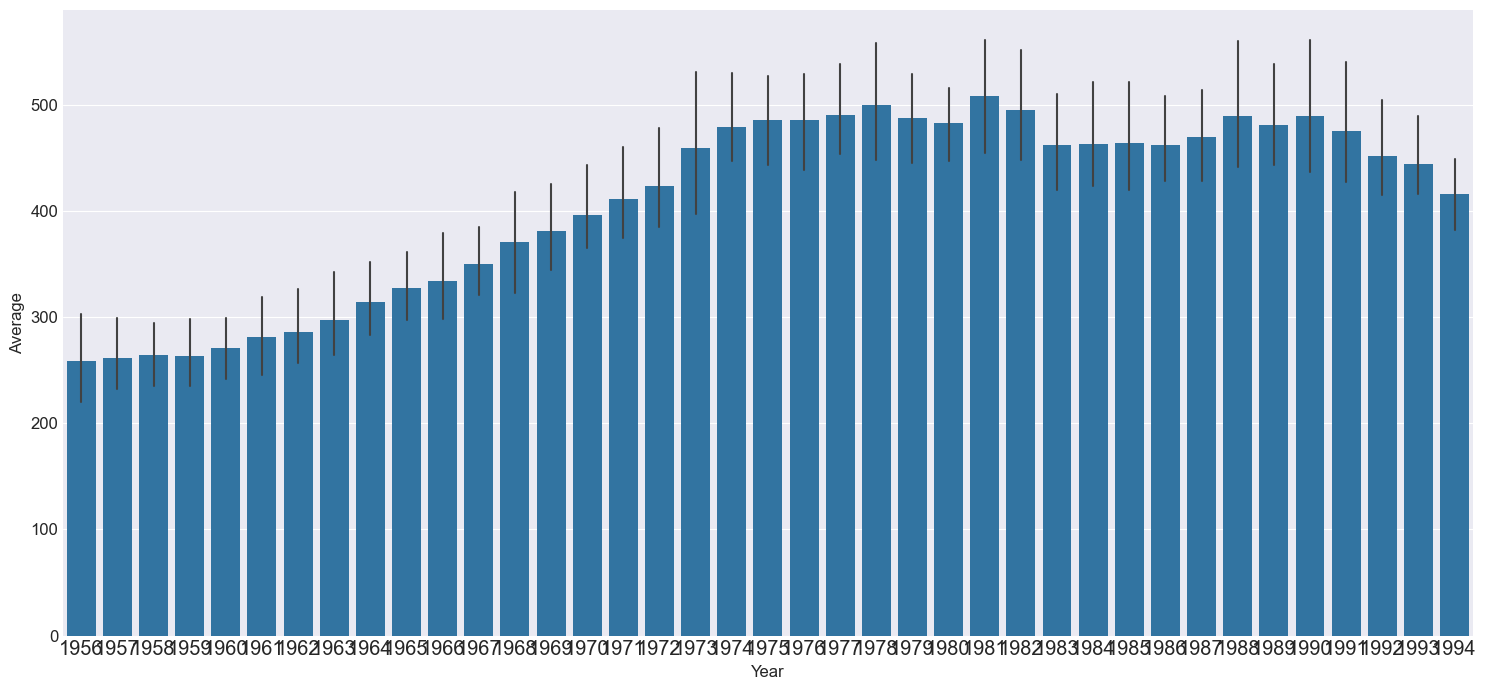

In [23]:
plt.figure()

bar = sns.barplot(data=data_df, x= 'year', y = 'production')
bar.set_ylabel('Average')
bar.set_xlabel('Year')

plt.tight_layout()

Text(0.5, 0, 'Month')

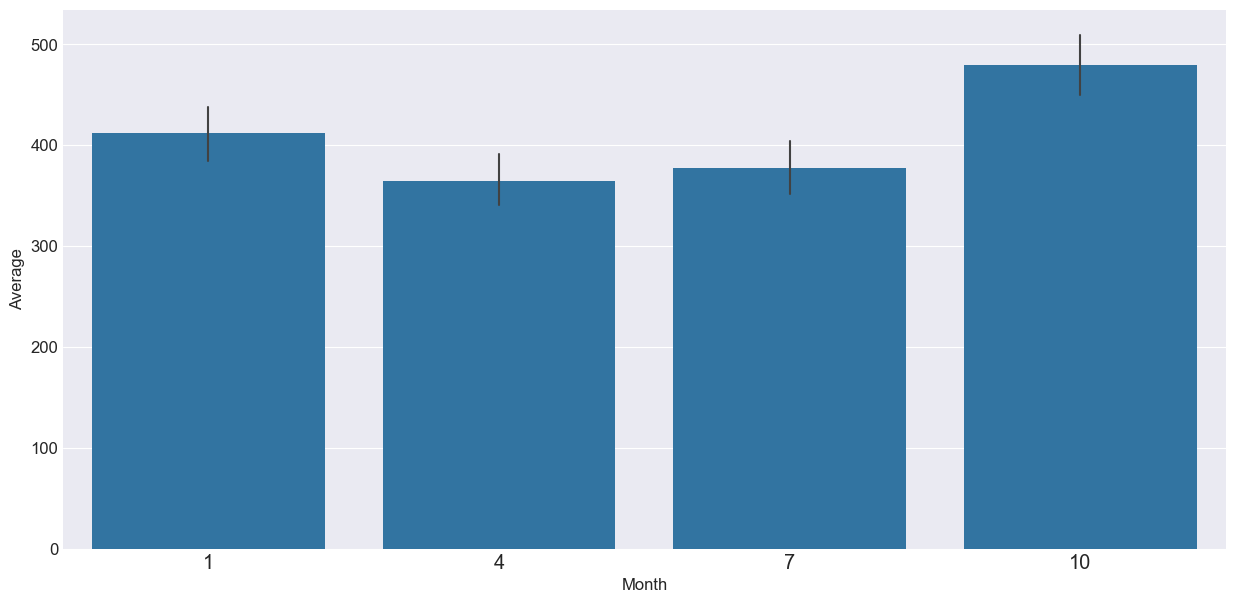

In [24]:
plt.figure()

bar = sns.barplot(data=data_df, x= 'month', y = 'production')
bar.set_ylabel('Average')
bar.set_xlabel('Month')

Text(0.5, 0, 'Month')

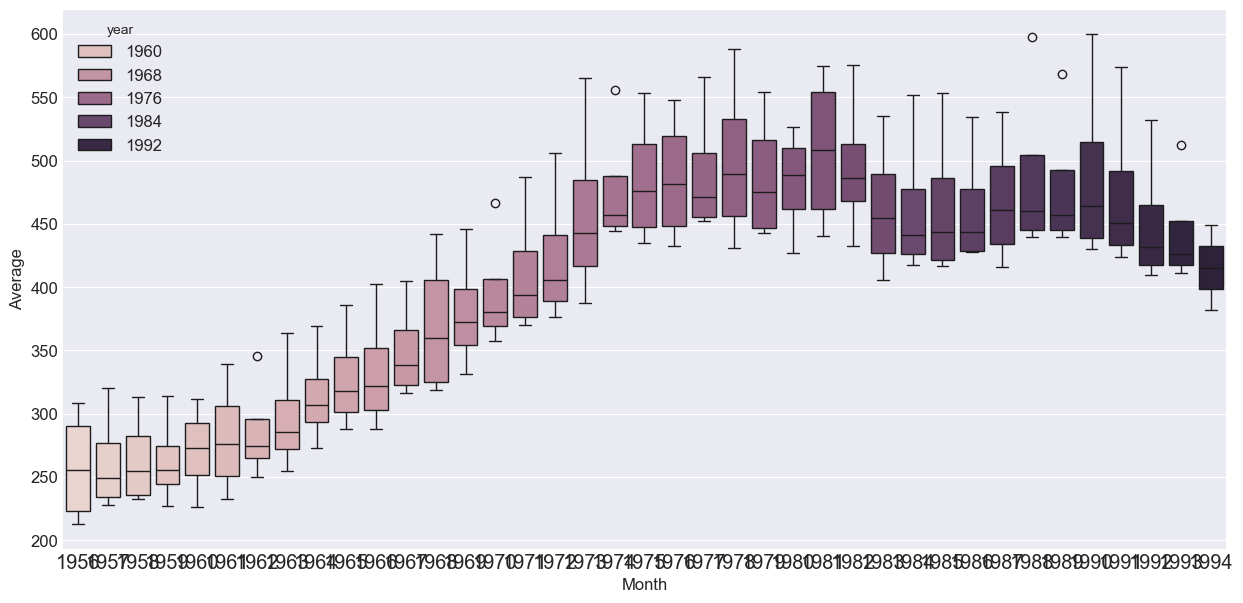

In [25]:
plt.figure()

bar = sns.boxplot(data=data_df, x= 'year', y = 'production', hue='year')
bar.set_ylabel('Average')
bar.set_xlabel('Month')

Text(0.5, 0, 'Year')

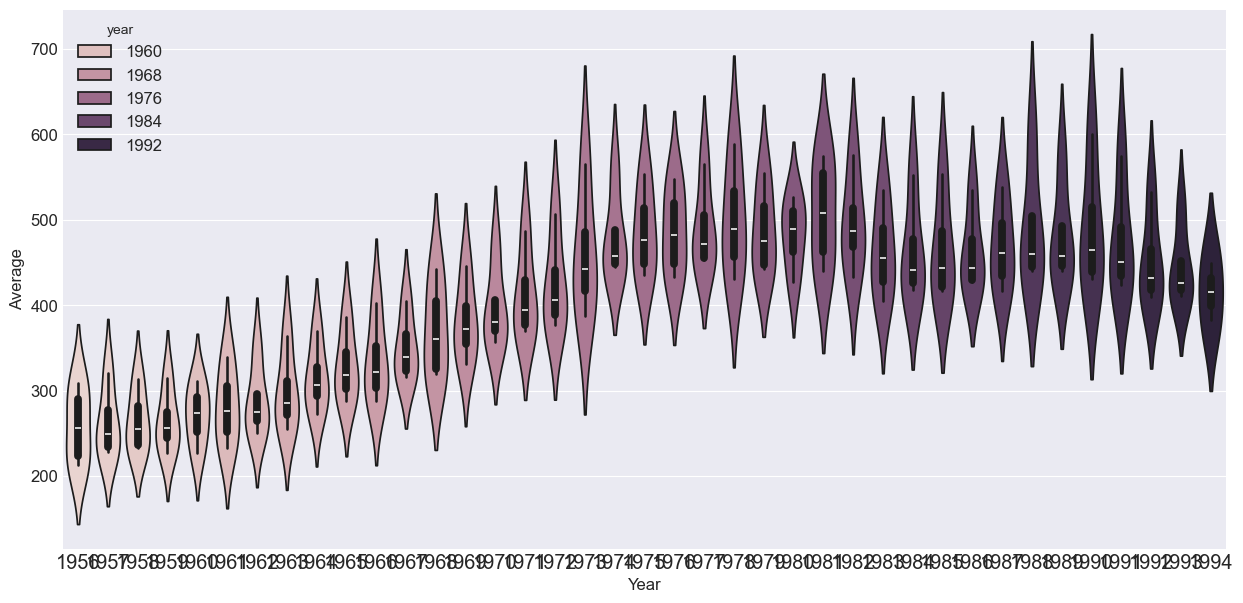

In [26]:
plt.figure()

bar = sns.violinplot(data=data_df, x= 'year', y = 'production', hue = 'year')
bar.set_ylabel('Average')
bar.set_xlabel('Year')

Text(0.5, 0, 'Month')

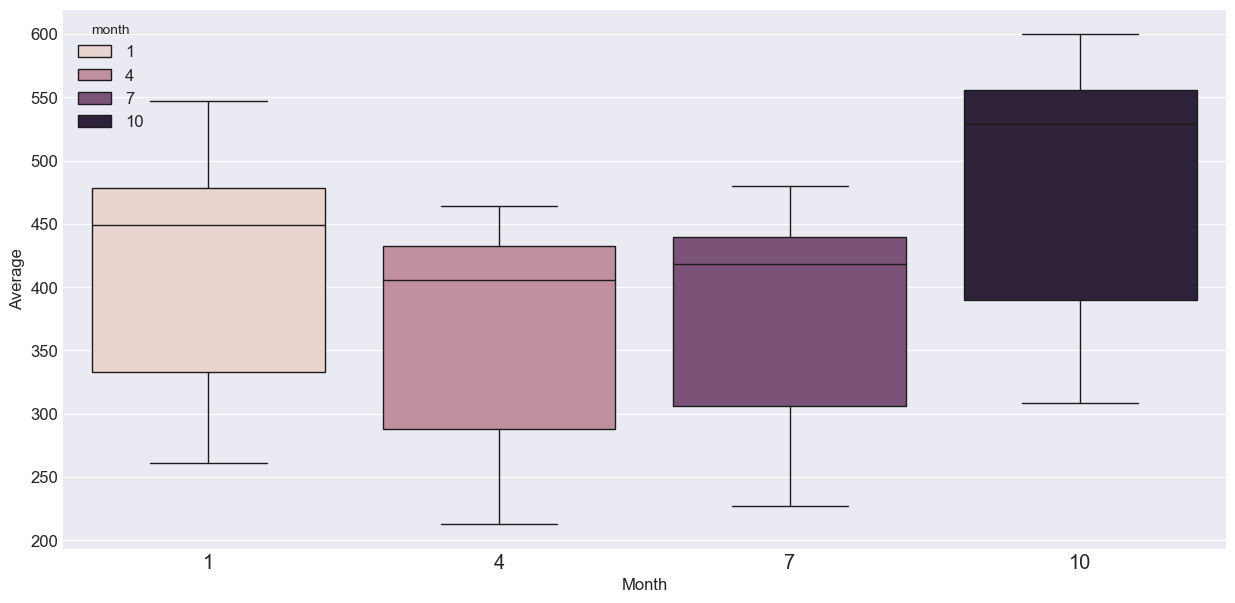

In [27]:
plt.figure()

bar = sns.boxplot(data=data_df, x= 'month', y = 'production', hue='month')
bar.set_ylabel('Average')
bar.set_xlabel('Month')

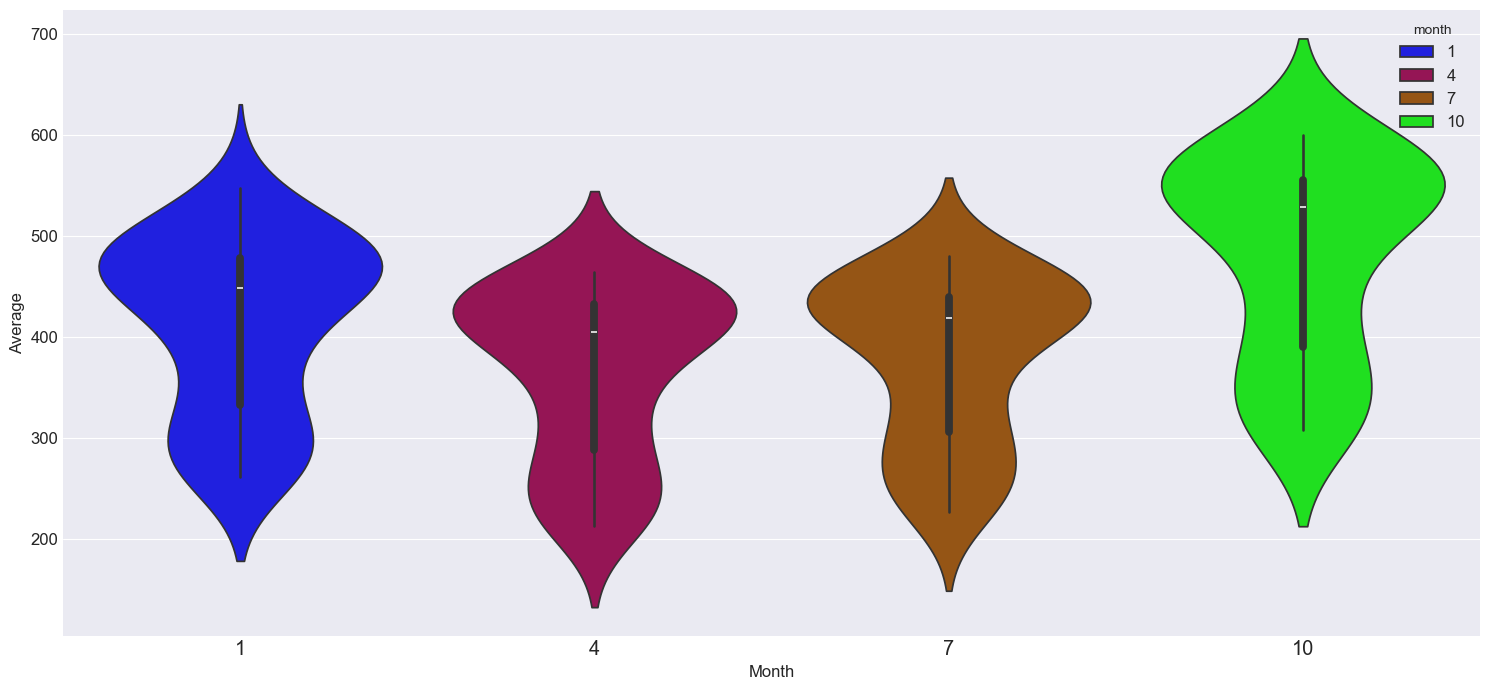

In [28]:
plt.figure()

bar = sns.violinplot(data=data_df, x= 'month', y = 'production', hue='month', palette= CMAP)
bar.set_ylabel('Average')
bar.set_xlabel('Month')

plt.tight_layout()

In [29]:
feature_df = data_df[['production']].copy()

feature_df.columns = ['T_i']
feature_df['T_(i-1)'] = feature_df['T_i'].shift(1)
feature_df['T_(i-2)'] = feature_df['T_i'].shift(2)
feature_df=feature_df.drop(feature_df.index[[0,1]])
feature_df.head()

,T_i,T_(i-1),T_(i-2)
2,226.9,212.8,284.4
3,308.4,226.9,212.8
4,262.0,308.4,226.9
5,227.9,262.0,308.4
6,236.1,227.9,262.0


In [30]:
reg=LinearRegression()
X = feature_df[['T_(i-1)']]
y = feature_df[['T_i']]

model = reg.fit(X,y)

feature_df['Pred_T_i|T_i-1']=reg.predict(X)

feature_df['Res_T_i|T_i-1']=feature_df['T_i']-feature_df['Pred_T_i|T_i-1']
feature_df.head()

,T_i,T_(i-1),T_(i-2),Pred_T_i|T_i-1,Res_T_i|T_i-1
2,226.9,212.8,284.4,266.569931,-39.669931
3,308.4,226.9,212.8,276.890645,31.509355
4,262.0,308.4,226.9,336.545840,-74.545840
5,227.9,262.0,308.4,302.582637,-74.682637
6,236.1,227.9,262.0,277.622611,-41.522611


### Second time series residue

In [32]:
reg=LinearRegression()
X = feature_df[['T_(i-1)']]
y = feature_df[['T_(i-2)']]

model = reg.fit(X,y)
feature_df['Pred_T_i-2|T_i-1']=reg.predict(X)

feature_df['Res_T_i-2|T_i-1']=feature_df['T_(i-2)']-feature_df['Pred_T_i-2|T_i-1']

feature_df.head()

,T_i,T_(i-1),T_(i-2),Pred_T_i|T_i-1,Res_T_i|T_i-1,Pred_T_i-2|T_i-1,Res_T_i-2|T_i-1
2,226.9,212.8,284.4,266.569931,-39.669931,260.882692,23.517308
3,308.4,226.9,212.8,276.890645,31.509355,271.453977,-58.653977
4,262.0,308.4,226.9,336.545840,-74.545840,332.557499,-105.657499
5,227.9,262.0,308.4,302.582637,-74.682637,297.769727,10.630273
6,236.1,227.9,262.0,277.622611,-41.522611,272.203713,-10.203713


In [33]:
feature_df.corr(method='pearson')['Res_T_i|T_i-1']['Res_T_i-2|T_i-1']

0.09923963983280493

In [34]:
acf(feature_df['T_i'],nlags=1)

array([1.        , 0.72597669])

In [35]:
acf(feature_df['T_i'],nlags=2)

array([1.        , 0.72597669, 0.57794875])

In [36]:
pacf(feature_df['T_i'],nlags=1)

array([1.        , 0.73078448])

In [37]:
pacf(feature_df['T_i'],nlags=2)

array([1.        , 0.73078448, 0.11075937])

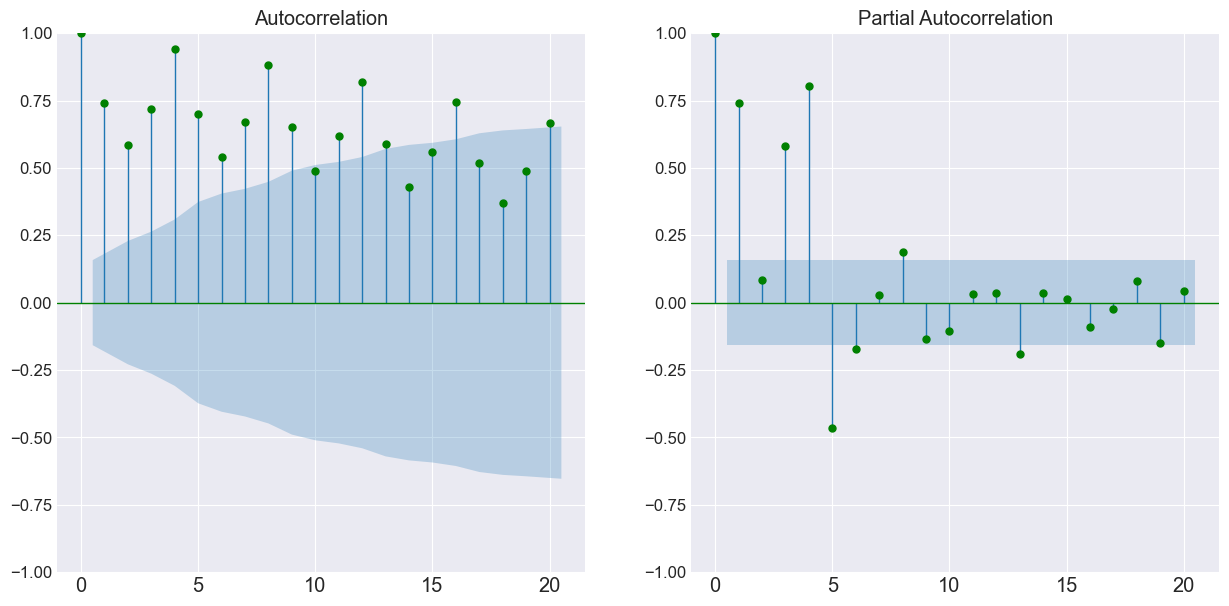

In [38]:
fig,axes = plt.subplots(1,2)
_=plot_acf(data_df['production'], lags = 20, color = 'g', ax = axes[0])
_=plot_pacf(data_df['production'], lags = 20, color = 'g', ax = axes[1])

<h4>Holts trend method</h4>

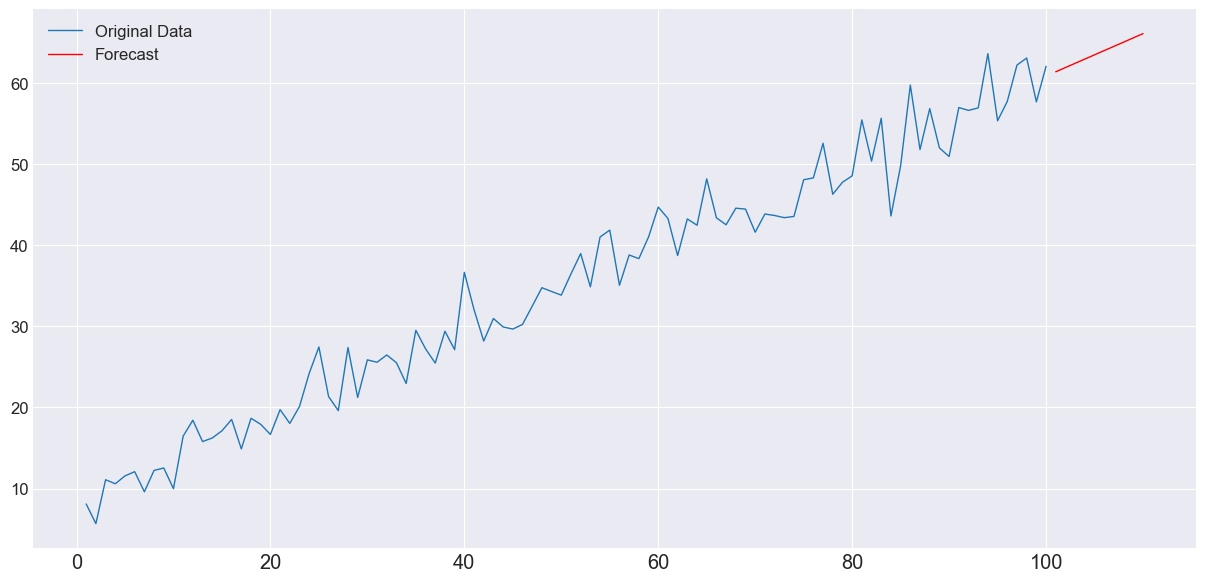

In [84]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Simulated data with  a linear trend
time =np.arange(1,101)
data =10+0.5 *time +np.random.normal(scale=3,size=100)

#holts linear trend model
holt_model =ExponentialSmoothing(data,trend='add',seasonal =None,damped_trend=False)
holt_fit = holt_model.fit()

# Forecasting for the next 10 time periods
forecast= holt_fit.forecast(steps=10)

#plotting the results
plt.plot(time,data,label ='Original Data')
plt.plot(np.arange(101,111),forecast,label='Forecast',color='red')
plt.legend()
plt.show()

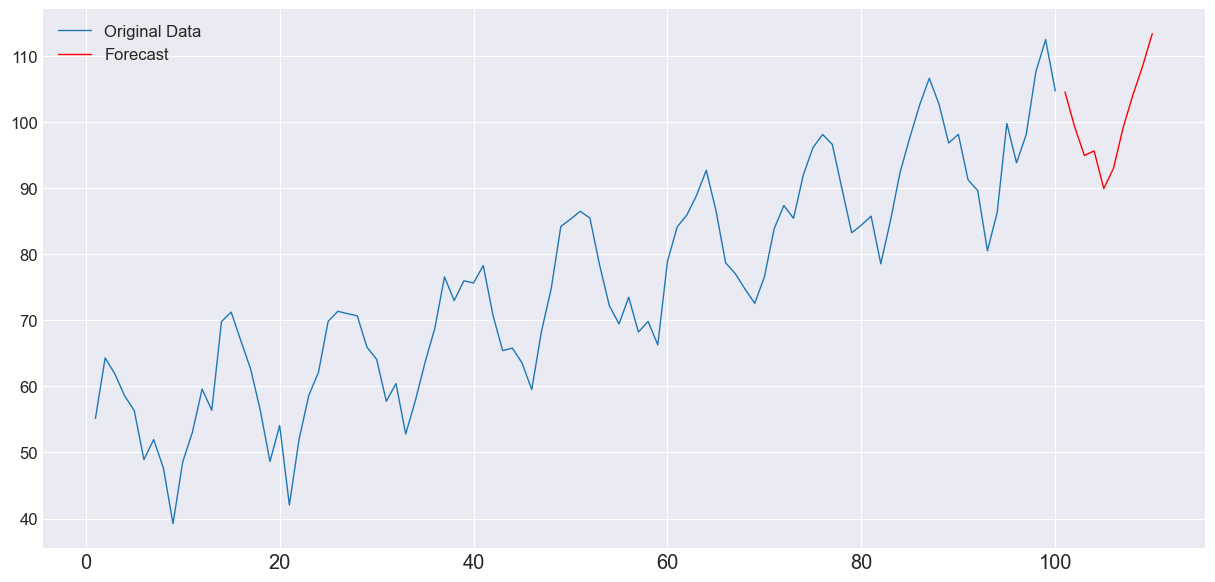

In [88]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Simulated data with  a linear trend and seasonality
time =np.arange(1,101)
seasonal = 10 * np.sin(2* np.pi * time/12) #12 month seasonality
data = 50 + 0.5 * time + seasonal + np.random.normal(scale=3,size=100)

#holts winters seasonal model  additive seasonality 
hw_model =ExponentialSmoothing(data,trend='add',seasonal ='add', seasonal_periods=12)
hw_fit = hw_model.fit()

# Forecasting for the next 10 time periods
forecast= hw_fit.forecast(steps=10)

#plotting the results
plt.plot(time,data,label ='Original Data')
plt.plot(np.arange(101,111),forecast,label='Forecast',color='red')
plt.legend()
plt.show()